# Code to read data with feature view from Hopsworks, trains a model to predict wine quality and uploads the model to Hopsworks

In [17]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn import tree
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [18]:
# Log in to Hopsworks and get feature store
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/193689
Connected. Call `.close()` to terminate connection gracefully.


In [19]:
# Extract the feature view from Hopsworks, which is the input set of features to the model
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(
    name="wine", 
    version=1,
    description="Read from Wine dataset",
    labels=["quality"],
    query=query
)

In [20]:
# Randomly split the training data into train/test sets of features X and labels y (test size -> 0.2=20%)
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# Let's find out what model fits our data the best
trainingModels = [
    KNeighborsClassifier(n_neighbors=2),
    LinearRegression(),
    tree.DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
]

scoreArray = [0]*len(trainingModels)

for i, m in enumerate(trainingModels):
    m = m.fit(X_train, y_train.values.ravel())
    score = m.score(X_test, y_test)
    scoreArray[i] += score
    print(m, score)

# Best model for our data turns out to be the RandomForest classifier model
print("Best model:", trainingModels[scoreArray.index(max(scoreArray))])

# Train the model with the random forest algorithm (Scikit-learn)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (1.93s) 


KNeighborsClassifier(n_neighbors=2) 0.40150093808630394
LinearRegression() 0.3037532817222116
DecisionTreeClassifier() 0.4521575984990619
RandomForestClassifier() 0.5590994371482176
Best model: RandomForestClassifier()


RandomForestClassifier(random_state=42)

In [21]:
# For comparison, let's also train the model with the K-nearest-neighbor algorithm (Scikit-learn) using our features (X_train) and labels (y_train)
model_knn = KNeighborsClassifier(n_neighbors=2)
model_knn.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [22]:
X_train

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,0,7.5,0.170,0.71,11.8,0.038,52.0,148.0,0.99801,3.03,0.46,8.9
1,1,8.5,0.655,0.49,6.1,0.122,34.0,151.0,1.00100,3.31,1.14,9.3
2,1,5.0,0.380,0.01,1.6,0.048,26.0,60.0,0.99084,3.70,0.75,14.0
3,0,7.2,0.230,0.39,14.2,0.058,49.0,192.0,0.99790,2.98,0.48,9.0
4,0,7.4,0.250,0.49,1.1,0.042,35.0,156.0,0.99170,3.13,0.55,11.3
...,...,...,...,...,...,...,...,...,...,...,...,...
5324,0,7.1,0.260,0.37,5.5,0.025,31.0,105.0,0.99082,3.06,0.33,12.6
5325,0,6.4,0.230,0.35,10.3,0.042,54.0,140.0,0.99670,3.23,0.47,9.2
5326,0,6.8,0.340,0.44,6.6,0.052,28.0,156.0,0.99550,3.14,0.41,9.6
5327,1,12.2,0.480,0.54,2.6,0.085,19.0,64.0,1.00000,3.10,0.61,10.5


In [23]:
y_train

,quality
0,5
1,5
2,6
3,7
4,5
...,...
5324,8
5325,5
5326,5
5327,6


In [24]:
# As you can see, ca. 80% (4263/5328 rows) of the data is training data
X_train.count()

type                    4263
fixed_acidity           4263
volatile_acidity        4263
citric_acid             4263
residual_sugar          4263
chlorides               4263
free_sulfur_dioxide     4263
total_sulfur_dioxide    4263
density                 4263
ph                      4263
sulphates               4263
alcohol                 4263
dtype: int64

In [25]:
# As you can see, ca. 20% (1066/5328 rows) of the data is test data
X_test.count()


type                    1066
fixed_acidity           1066
volatile_acidity        1066
citric_acid             1066
residual_sugar          1066
chlorides               1066
free_sulfur_dioxide     1066
total_sulfur_dioxide    1066
density                 1066
ph                      1066
sulphates               1066
alcohol                 1066
dtype: int64

In [26]:
# Evaluate the model performance using features from test set (X_test)
y_pred_knn = model_knn.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

# Compare predictions made by the model (y_pred) with the labels in the test set (y_test) for the knn algorithm
metrics_knn = classification_report(y_test, y_pred_knn, output_dict=True)
results_knn = confusion_matrix(y_test, y_pred_knn)

# Compare with random forest algorithm
metrics_rf = classification_report(y_test, y_pred_rf, output_dict=True)
results_rf = confusion_matrix(y_test, y_pred_rf)

metricslist = [metrics_knn, metrics_rf]

# Print the metrics 
for metrics in metricslist:
    for metric in metrics:
        print(metric, metrics[metric])

3 {'precision': 0.07142857142857142, 'recall': 0.14285714285714285, 'f1-score': 0.09523809523809523, 'support': 7}
4 {'precision': 0.15294117647058825, 'recall': 0.3170731707317073, 'f1-score': 0.20634920634920637, 'support': 41}
5 {'precision': 0.4309278350515464, 'recall': 0.5805555555555556, 'f1-score': 0.49467455621301787, 'support': 360}
6 {'precision': 0.44, 'recall': 0.43287037037037035, 'f1-score': 0.43640606767794626, 'support': 432}
7 {'precision': 0.3157894736842105, 'recall': 0.09326424870466321, 'f1-score': 0.144, 'support': 193}
8 {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 32}
9 {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}
accuracy 0.40150093808630394
macro avg {'precision': 0.2015838652335595, 'recall': 0.2238029268884913, 'f1-score': 0.1966668464968951, 'support': 1066}
weighted avg {'precision': 0.3873658323404348, 'recall': 0.40150093808630394, 'f1-score': 0.3785452585370951, 'support': 1066}
3 {'precision': 0.0, 'recall': 0.0, '

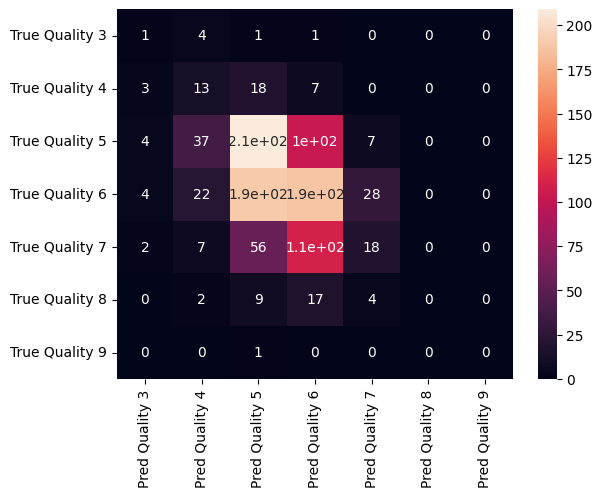

In [27]:
# Create confusion matrix that shows true values vs predicted values
df_cm_knn = pd.DataFrame(results_knn, 
                     ["True Quality 3", "True Quality 4", "True Quality 5", "True Quality 6", "True Quality 7", "True Quality 8", "True Quality 9"],
                     ["Pred Quality 3", "Pred Quality 4", "Pred Quality 5", "Pred Quality 6", "Pred Quality 7", "Pred Quality 8", "Pred Quality 9"]
                    )

cm_knn = sns.heatmap(df_cm_knn, annot=True)
fig_knn = cm_knn.get_figure()

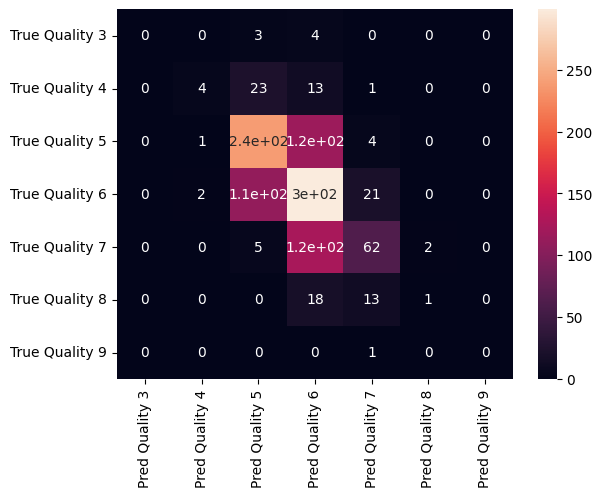

In [28]:
# Create confusion matrix that shows true values vs predicted values
df_cm_rf = pd.DataFrame(results_rf, 
                     ["True Quality 3", "True Quality 4", "True Quality 5", "True Quality 6", "True Quality 7", "True Quality 8", "True Quality 9"],
                     ["Pred Quality 3", "Pred Quality 4", "Pred Quality 5", "Pred Quality 6", "Pred Quality 7", "Pred Quality 8", "Pred Quality 9"]
                    )

cm_rf = sns.heatmap(df_cm_rf, annot=True)
fig_rf = cm_rf.get_figure()

In [29]:
# Get an object for model registry from Hopsworks
mr = project.get_model_registry()

# Create folder to store wine model if it does not exist
model_dir = "wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save model and conusfion matrix for rf to the correct folder. Both will be uploaded to model registry in Hopsworks
joblib.dump(model_rf, model_dir + "/wine_model_rf.pkl")
fig_rf.savefig(model_dir + "/confusion_matrix_rf.png")

# Specify schema of the model 
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create model in the model registry that includes the model name, metrics, schema and description
wine_model = mr.python.create_model(
    name="wine_model_rf",
    metrics={"accuray:" : metrics["accuracy"]},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload model to model registry with all files in the folder
wine_model.save(model_dir)



Connected. Call `.close()` to terminate connection gracefully.


Uploading: 100.000%|██████████| 32350/32350 elapsed<00:01 remaining<00:001,  3.10it/s]
Uploading: 100.000%|██████████| 32238/32238 elapsed<00:01 remaining<00:001,  3.10it/s]
Uploading: 100.000%|██████████| 24662433/24662433 elapsed<00:18 remaining<00:0010it/s]
Uploading: 100.000%|██████████| 24605761/24605761 elapsed<00:11 remaining<00:0010it/s]
Uploading: 100.000%|██████████| 1127/1127 elapsed<00:01 remaining<00:001:20, 20.18s/it]
Model export complete: 100%|██████████| 6/6 [00:42<00:00,  7.05s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/193689/models/wine_model_rf/3


Model(name: 'wine_model_rf', version: 3)